In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters for the normal distribution
mu = 0      # mean
sigma = 1   # standard deviation

# Parameters
L = 100 * 10**3.0
Total_time = 3000.0
g = 9.81
viscosity = 8.9*10**(-2)
# viscosity = 0
Nx = 500  # number of points in the spatial domain
dx = L / Nx
x = np.linspace(0, L, Nx)

In [5]:
# Generate a topographic profile
# final_height_coast = 1*10**3
# x_dist = np.linspace(mu - 4*sigma, mu + 7*sigma, Nx//5)
# x_dist1 = np.linspace(0.001,1,Nx//5)
# ramp = x_dist1*final_height_coast
# # cdf_values = norm.cdf(x_dist, loc=mu, scale=sigma) * final_height_coast
# coast = np.concatenate((np.zeros(Nx//3), ramp, np.ones(Nx-Nx//3 - Nx//5)*final_height_coast))  # This represents bed elevation (B)

coast = np.zeros_like(x)

In [6]:
coast[Nx//3 + Nx//5-1]

0.0

In [7]:
u_left = lambda t: 0
u_right = lambda t: 0

# Initial conditions: h is water depth above bed, not absolute water surface
# Start with a flat 0.5 m layer, then add a perturbation
eta_initial = np.zeros(Nx, dtype=np.float64)
u_initial = np.zeros(Nx, dtype=np.float64)

eta_initial[0:Nx//2] += 100
# Add a perturbation
# h_initial += 1.0

# # Make sure no negative depth
# eta_initial+=1200 - coast
# u_initial[:Nx//4]+=10

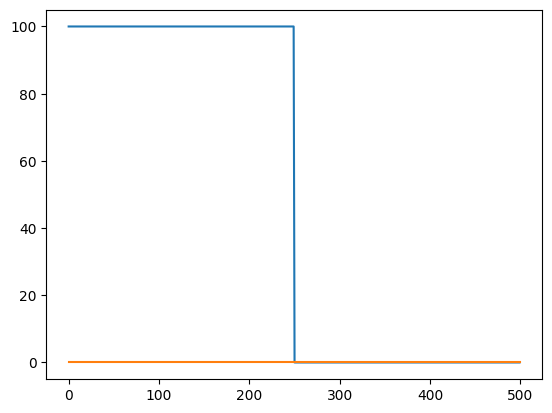

In [8]:
plt.plot(eta_initial+coast)
plt.plot(coast)

In [9]:
def pde_system_vector_op(t, y):
    eta = y[:Nx]
    u = y[Nx:]

    deta_dx = np.zeros(Nx, dtype=np.float64)
    du_dx = np.zeros(Nx, dtype=np.float64)
    deta_dt = np.zeros(Nx, dtype=np.float64)
    du_dt = np.zeros(Nx, dtype=np.float64)

    # Compute spatial derivatives
    deta_dx[1:-1] = (eta[2:] - eta[:-2]) / (2*dx)

    du_dx[1:-1] = (u[2:] - u[:-2]) / (2*dx)

    # Bed slope
    bx = np.zeros(Nx, dtype=np.float64)
    bx[1:-1] = (coast[2:] - coast[:-2]) / (2*dx)
    # bx[0] = (coast[1] - coast[0]) / dx
    # bx[-1] = (coast[-1] - coast[-2]) / dx

    # Shallow water equations in non-conservative form:
    # dh/dt = - (hu)_x = - (h u_x + u h_x)
    deta_dt [1:-1] = -(eta[1:-1] * du_dx[1:-1] + u[1:-1] * deta_dx[1:-1])

    # u_t + u u_x + g h_x = - g B_x + viscosity * u_xx/h?
    # For simplicity, just add viscosity on u separately as done before.
    u_xx = np.zeros(Nx, dtype=np.float64)
    u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2

    du_dt[1:-1] = (-u[1:-1] * du_dx[1:-1] - g * deta_dx[1:-1] + g * bx[1:-1] + viscosity * u_xx[1:-1])

    # Apply reflective BCs on du_dt and dh_dt (optional)
    # Here we keep them as is since we handle them in time stepper

    return np.concatenate((deta_dt, du_dt))

In [49]:
a = [1,2,3]
a[1:2]

[2]

In [10]:
def pde_system_vector_op(t, y): #No boundary conditions for eta
    eta = y[:Nx] # 0 Index used for point at boundary
    u = y[Nx:]# 0 index used for first real point in grid after boundary

    deta_dx = np.zeros(Nx, dtype=np.float64) #Also consider boundary for eta
    du_dx = np.zeros(Nx, dtype=np.float64)
    deta_dt = np.zeros(Nx, dtype=np.float64)
    du_dt = np.zeros(Nx, dtype=np.float64)
    db_dx = np.zeros(Nx, dtype=np.float64)

    db_dx[1:-1] = (coast[2:] - coast[:-2]) / (2*dx)
    deta_dx[1:-1] = (eta[2:] - eta[:-2]) / (2 * dx)
    du_dx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)

    deta_dt[1:-1] = -eta[1:-1] * du_dx[1:-1] - u[1:-1] * deta_dx[1:-1]
    du_dt[1:-1] = -u[1:-1] * du_dx[1:-1] - g * deta_dx[1:-1] + g*db_dx[1:-1] + viscosity *(u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    return np.concatenate((deta_dt, du_dt))

In [11]:
def compute_time_step_1D(y):
    safety_factor = 0.7
    h = y[:Nx]
    u = y[Nx:]
    c = np.sqrt(g * h)
    evals_1 = np.abs(u - c)
    evals_2 = np.abs(u + c)
    max_eval = max(np.max(evals_1), np.max(evals_2), 1e-6)
    time_step = safety_factor * dx / max_eval
    return time_step

In [70]:
def laxFriedrichs(y0, tspan, ode):
    t0, tend = tspan
    t = [t0]
    y = [y0.copy()]
    step = 0
    eta_data = []

    while t0 < tend:
        current_y = y[-1]
        # delta_t = compute_time_step_1D(current_y)
        delta_t = 20
        if t0 + delta_t > tend:
            delta_t = tend - t0
        
        derivative = ode(t0, current_y)

        y_next = current_y
        print(len(y_next))
        y_next[1: Nx-1] = 0.5 * (current_y[2: Nx] - current_y[:Nx - 2]) - delta_t/(2 * dx) * (derivative[2: Nx] - derivative[:Nx -2])
        y_next[Nx + 1: -1] = 0.5 * (current_y[Nx + 2:] - current_y[Nx: -2]) - delta_t/(2 * dx) * (derivative[Nx + 2:] - derivative[Nx: -2])
        eta_next = y_next[:Nx]
        u_next = y_next[Nx:]

        # Ensure no negative depth
        # eta_next = np.maximum(eta_next, 0)
        print(eta_next)
        u_next[0] = u_left(t0)
        u_next[-1] = u_right(t0)
        eta_next[0] = eta_next[1]
        eta_next[-1] = eta_next[-2]

        # Recombine
        y_next = np.concatenate((eta_next, u_next))
        # print(step)
        t0 += delta_t
        t.append(t0)
        y.append(y_next.copy())
        step += 1
        if step % 10 == 0:
            eta_data.append(eta_next.copy())

    return t, y, np.array(eta_data)


In [71]:
def rungeKutta_1D(y0, tspan, ode):
    t0, tend = tspan
    t = [t0]
    y = [y0.copy()]

    step = 0
    eta_data = []

    while t0 < tend:
        delta_t = compute_time_step_1D(y[-1])
        # delta_t = 20
        if t0 + delta_t > tend:
            delta_t = tend - t0

        k1 = ode(t0, y[-1])
        k2 = ode(t0 + 0.5*delta_t, y[-1] + 0.5*delta_t*k1)
        k3 = ode(t0 + 0.5*delta_t, y[-1] + 0.5*delta_t*k2)
        k4 = ode(t0 + delta_t, y[-1] + delta_t*k3)

        y_next = y[-1] + (delta_t/6.0)*(k1 + 2*k2 + 2*k3 + k4)

        # Extract h and u
        eta_next = y_next[:Nx]
        u_next = y_next[Nx:]

        # Ensure no negative depth
        eta_next = np.maximum(eta_next, 0)


        # Boundary conditions: reflective
        u_next[0] = u_left(t0)
        u_next[-1] = u_right(t0)
        eta_next[0] = eta_next[1]
        eta_next[-1] = eta_next[-2]
        # eta_next[Nx//3 + 1] = (eta_next[Nx//3] + eta_next[Nx//3 + 2])/2
        # eta_next[Nx//3 + Nx//5-1] = (eta_next[Nx//3 + Nx//5-2] + eta_next[Nx//3 + Nx//5])/2

        # Recombine
        y_next = np.concatenate((eta_next, u_next))
        # print(step)
        t0 += delta_t
        t.append(t0)
        y.append(y_next.copy())
        step += 1
        if step % 10 == 0:
            eta_data.append(eta_next.copy())

    return t, y, np.array(eta_data)


In [72]:
eta_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
y0 = np.concatenate((eta_initial, u_initial))
t_values, solution_values, eta_data = laxFriedrichs(y0, (0.0, Total_time), pde_system_vector_op)

1000
[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 

In [54]:
eta_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y0 = np.concatenate((eta_initial, u_initial))
t_values, solution_values, eta_data = rungeKutta_1D(y0, (0.0, Total_time), pde_system_vector_op)

C:\Users\20210828\AppData\Local\Temp\ipykernel_9972\848614166.py:20: RuntimeWarning: overflow encountered in add
  y_next = y[-1] + (delta_t/6.0)*(k1 + 2*k2 + 2*k3 + k4)
C:\Users\20210828\AppData\Local\Temp\ipykernel_9972\848614166.py:16: RuntimeWarning: invalid value encountered in multiply
  k2 = ode(t0 + 0.5*delta_t, y[-1] + 0.5*delta_t*k1)


In [34]:
solution_values = np.array(solution_values)
h_results = [eta_data[i] + coast for i in range(len(eta_data)-1)] 
time_steps = len(h_results)

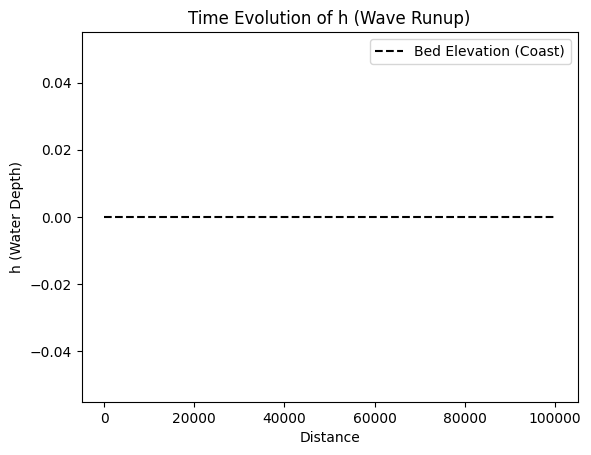

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

In [42]:
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
# ax.set_xlim(x.min(), x.max())
# ax.set_ylim(-1, final_height_coast*1.5)
ax.set_xlabel("Distance")
ax.set_ylabel("h (Water Depth)")
ax.set_title("Time Evolution of h (Wave Runup)")
ax.plot(x, coast, label='Bed Elevation (Coast)', color='k', linestyle='--')
ax.legend()

values = h_results

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = values[frame]
    line.set_data(x, y)
    return line,

ani = FuncAnimation(fig, update, frames=range(time_steps), init_func=init, blit=True, interval=20)
plt.show()
ani.save('wave_to_coast.gif', writer='ffmpeg', fps=30)